In [209]:
%matplotlib inline
import pysal as ps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Point
import seaborn as sns
from matplotlib import cbook
import spvcm.api as spvcm 
import sys
from spvcm import plotting
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In this notebook we undertake various diagnostic tests on the spatial hierarchical models defined using the SPVCM module.

In [1]:
# path = '/media/sam/sam_hdd/manchester_case_study/'
path = 'c:/Users/sgscombe/Documents/manchester_case_study/'

# read manchester shapefile and ldc stores 
manc = gpd.read_file(path+'manchester_catchments.shp')

ldc_data = pd.read_csv(path + '/data/modelling_hsar.csv')
ldc_data = ldc_data[ldc_data['PremiseStatus'] == 'Live'] 

# convert to geopandas
geometry = [Point(xy) for xy in zip(ldc_data['Geocode Easting'].astype(float), ldc_data['Geocode Northing'].astype(float))]
ldc_data_gpd = gpd.GeoDataFrame(ldc_data, crs=manc.crs, geometry=geometry)
ldc_data = sjoin(ldc_data_gpd.drop('index_right', axis=1), manc[['geometry']], op='within')

# keep only intersecting catchments
catchments = gpd.read_file(path+'shps/m_weights.shp')
catchments = catchments[catchments.cluster_id.isin(ldc_data.cluster_id.tolist())] 
catchments = catchments.drop_duplicates(subset='cluster_id')
catchments = catchments.set_index('cluster_id').sort_index()

# build lower-level design matrix
dummies_store_category = pd.get_dummies(ldc_data.cat_Name1).columns # store categories
ldc_data = ldc_data.merge(pd.get_dummies(ldc_data.cat_Name1), left_index=True, right_index=True)
ldc_data = ldc_data.sort_values('cluster_id') 
features_store_category = dummies_store_category.tolist()
features_store_category.remove('Showrooms') # drop reference dummies
features = list(cbook.flatten(['no_rooms', 'total_area', 'car_park_spaces', 
                               features_store_category]))

# use gravity weights to define neighbours
m = ps.weights.DistanceBand.from_dataframe(catchments,
                                           threshold=5000,  # inferred from variogram
                                           binary=False,
                                           alpha = -2.0);
m.dmat

<130x130 sparse matrix of type '<class 'numpy.float64'>'
	with 1892 stored elements in Compressed Sparse Row format>

First of all we define the lower and higher level variables.

In [2]:
# lower-level design matrix
X = ldc_data[features].values 
# observations
N = X.shape[0]
# higher-level design matrix
Z = np.eye(catchments.shape[0])
# regions
J = Z.shape[0]
# response
Y = ldc_data.total_value.values.reshape(-1, 1)
Y = np.log(Y)

# N x J
membership = ldc_data.cluster_id.apply(lambda x: m.id_order.index(x)).values

print(X.shape, sep='\n')
print(Z.shape, sep='\n')

(14982, 16)
(130, 130)


Our benchmark model uses non-informative prior distributions which we outline below. For example, $\beta_k$ is a $k$-dimensional multivariate normal prior.

$$
\beta_k \sim MVN(0, \sum_{\beta0}) \\
\sum_{\beta 0} \sim Inv-Wishart(I \ 100) \\
\tau \sim Inv-Gamma(0.001, 0.0001) \\
\sigma_e \sim Inv-Gamma(0.001, 0.001) \\
\lambda \sim Uniform(-1, 1)\\
$$


In [186]:
p = len(features) + 1 # p variables + 1 for intercept

def constant(*args, **kwargs):
    return 0

# create grid of different prior values 
priors = {'Betas_mean0': [np.zeros((p,1)), np.zeros((p,1)), np.zeros((p,1)), np.zeros((p,1))], 
          'Betas_cov0': [np.eye(p)*100, np.eye(p)*100, np.eye(p)*100, np.eye(p)*100],
          'Sigma2_a0': [.001, .0001, 0.01, 0.1],
          'Sigma2_b0': [.001, .0001, 0.01, 0.1],
          'Tau2_a0': [.001, .001, 0.01, 0.1],
          'Tau2_b0': [.0001, .001, 0.01, 0.1],
          'Log_Lambda0': [constant, constant, constant, constant]
         }

# create scenarios of different priors
priors_default = {k:v[0] for k,v in priors.items()}
priors_low = {k:v[1] for k,v in priors.items()}
priors_mid = {k:v[2] for k,v in priors.items()}
priors_ext = {k:v[3] for k,v in priors.items()}

Let's define a boxplot function that sorts the regional effect ($\theta_j$) by the median value then use this plot to describe any discrepancies caused by using different prior specifications.

In [224]:
def boxplot_models(model, sort=False, burnin=1000):
    
    intercept = spvcm.diagnostics.point_estimates(model, burnin=burnin)[0]['Betas'][0]
    vals = (sese.trace.to_df().iloc[burnin:].filter(regex='Alpha') + intercept).T
    vals.index = ldc_data['cluster_id'].unique().tolist()
    
    if sort == True:
        vals = vals.T.reindex_axis(vals.T.median().sort_values(ascending=False).index, axis=1).T
    else:
        vals = vals.reindex_axis(vals.median().sort_values(ascending=False).index, axis=1)

    labels = vals.index.tolist()

    fig = plt.figure(1, figsize=(12, 6))

    range_vals = 10

    # Create an axes instance
    ax = fig.add_subplot(111)
    # Create the boxplot
    bp = ax.boxplot(list(vals.values)[0:range_vals], patch_artist=True)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#eef442', linewidth=2)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='#000000', linewidth=2)
        # change fill color
        box.set( facecolor = '#f44242' )

    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

    plt.title(r'Top {} Town Centre Boundaries ($\theta_j$)'.format(range_vals), size=15, fontweight='bold')
    ax.set_xticklabels(labels[0:range_vals])
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# compare default priors to grid for upper-level spatial error model
sese_default_prior = spvcm.upper.SE(Y, X,M=m, membership=membership, priors=priors_default,
                         n_samples=11000, n_jobs=1, 
                         configs=dict(tuning=500, adapt_step=1.01));

sese_test_prior = spvcm.upper.SE(Y, X,M=m, membership=membership, priors=priors_ext,
                         n_samples=11000, n_jobs=1, 
                         configs=dict(tuning=500, adapt_step=1.01));

We compare our default non-informative priors for the parameters $\theta^* = \{ \lambda, \beta, \theta, \sigma_e^2, \sigma_u^2\}$ to an 'extreme' case where we have incremented the prior values for the shape parameters 100-fold.

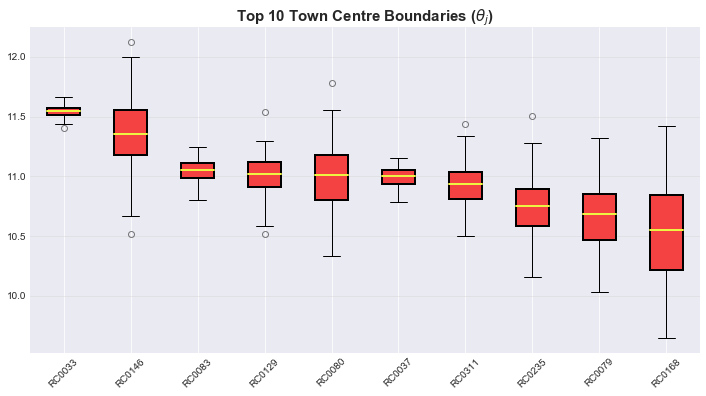

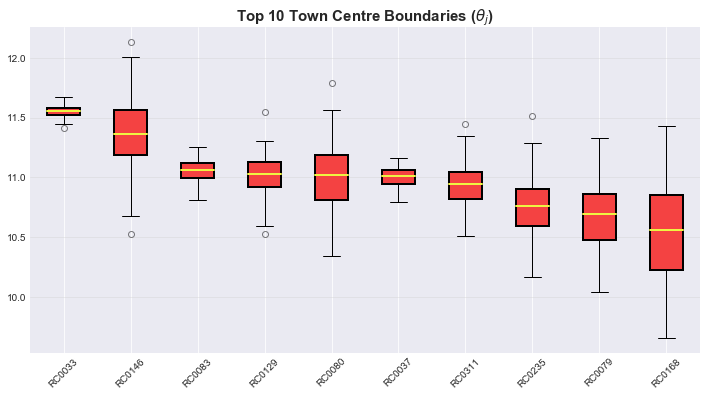

In [225]:
boxplot_models(sese_default_prior, sort=True, burnin=1000)
boxplot_models(sese_test_prior, sort=True, burnin=1000)

Now let's check out the SMA model.

In [189]:
sma_test_default = spvcm.upper.SMA(Y, X,M=m, membership=membership, priors=priors_default,
                         n_samples=11000, n_jobs=1, 
                         configs=dict(tuning=500, adapt_step=1.01));

sma_test_extreme = spvcm.upper.SMA(Y, X,M=m, membership=membership, priors=priors_ext,
                         n_samples=11000, n_jobs=1, 
                         configs=dict(tuning=500, adapt_step=1.01));

As can be oberved, there are no systematic discrepancies when generating posterior samples of the parameters when we use different prior specifications. This suggests the likelihoods are very peaked relative to the priors, with variation in the prior means having almost no impact on posterior means.

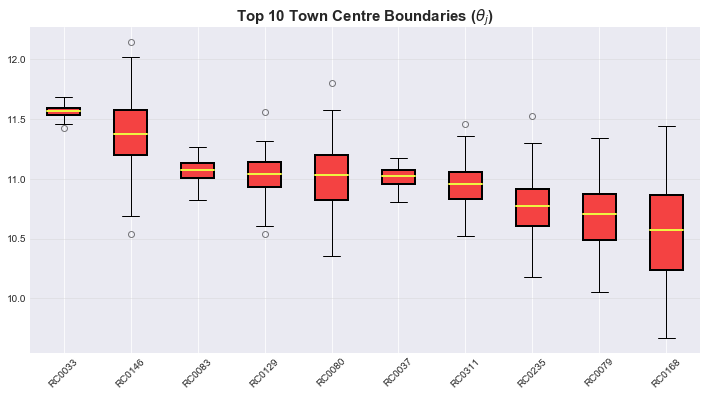

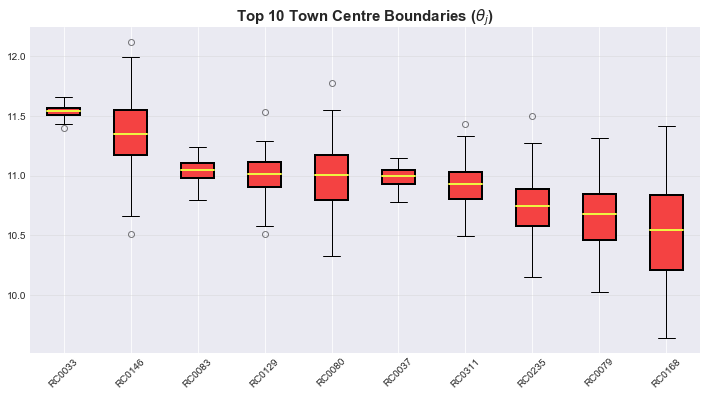

In [226]:
boxplot_models(sma_test_default, sort=True, burnin=1000)
boxplot_models(sma_test_extreme, sort=True, burnin=1000)

Let's check the partial autocorrelation to see whether each draw from the target distribution(s) are correlated to the previous draw.

In time series analysis, the partial autocorrelation function (PACF) gives the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags.

In [430]:
%%capture
from statsmodels.api import tsa

sns.set_style("darkgrid")

sma_df = sma_test_default.trace.to_df().iloc[1000:]

params = [c for c in sma_df.columns if c.startswith(('Lambda', 'Sigma2', 'Tau2', 'Beta'))][0:5]

nlags = 40

f,ax = plt.subplots(len(params), 2, figsize=(10,8))
for i, col in enumerate(params):
    ax[i,0].plot(tsa.acf(sma_df[col].values, nlags=nlags), color='#ff0000')
    ax[i,1].plot(tsa.pacf(sma_df[col].values, nlags=nlags), color='#ff0000')
    ax[i,0].set_title(col +' (ACF)')
    ax[i,1].set_title('(PACF)')
f.tight_layout()
plt.show();

Plotting the autocorrelation of the parameter chains reveals some interesting findings. For one, all the parameters seem to exhibit ~0 correlation as you increase the number of lags ($x$-axis limits from 0-40). However, $\beta_0$ appears reach 0.5 at lag 40, indicting the sampling process is not mixing well, and that sucessive steps in the chain are near each other. This creates a clumpy chain that takes a longer time to smooth out. 

Interesting, this seems to contradict Kruschke's (2015) heuristic that stable estimates can be obtained for a chain ran for 10,000 iterations. In all, this would suggest the MCMC chain has gotten stuck in a subset of the posterior distribution, rather than exploring the entire posterior parameter space.

On the other hand, when you consider partial correlation of the MCMC chain (which controls for values of the chain at all shorter lags), the finding we observe above is reversed, with all parameters showing ~0 partial correlation as you increase the number of lags.

In all, autocorrelation within the MCMC parameter chains does not seem to be an issue. Note: $\beta_{2-15}$ are omitted to save space, but they practically reveal the same autocorrelation structure as $\beta_1$.

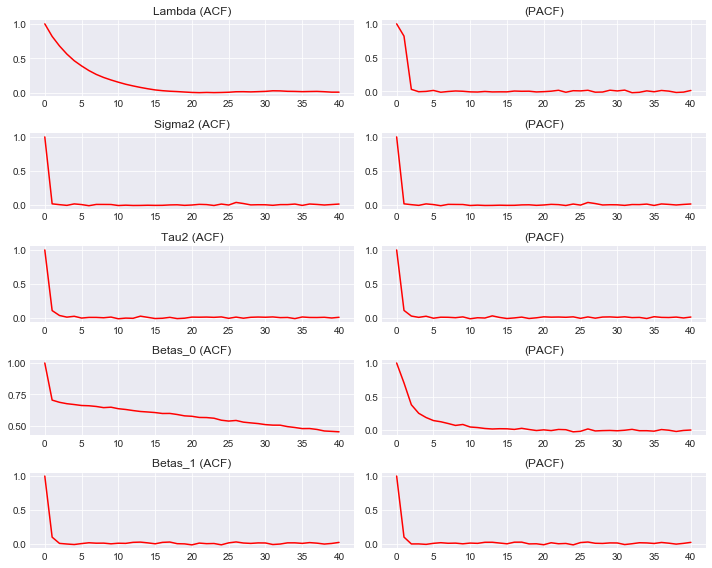

In [253]:
f

Now let's look at the highest posterior density (HPD) intervals for a select number of parameters.

In [256]:
HPDs = spvcm.diagnostics.hpd_interval(trace=sese.trace, p=.95)

In [446]:
%%capture
from matplotlib import rcParams
rcParams['axes.titlepad'] = 8

f, axarr = plt.subplots(2,2, figsize=(12,6))

pts = sns.kdeplot(sese.trace.to_df()['Lambda'].values, shade=True, color='r', alpha=.9, ax=axarr[0, 0]).get_lines()[0].get_data()
x,y = pts[0], pts[1]
lower, upper = HPDs['Lambda'][0], HPDs['Lambda'][1]

axarr[0, 0].fill_between(x,y, where = x >=upper, color='#fbff0f')
axarr[0, 0].fill_between(x,y, where = x <= lower, color='#fbff0f')
axarr[0, 0].set_title(r'$\lambda$', size=20, fontweight='bold')

pts = sns.kdeplot(sese.trace.to_df()['Sigma2'].values, shade=True, color='r', alpha=.9, ax=axarr[0, 1]).get_lines()[0].get_data()
x,y = pts[0], pts[1]
lower, upper = HPDs['Sigma2'][0], HPDs['Sigma2'][1]

axarr[0, 1].fill_between(x,y, where = x >=upper, color='#fbff0f')
axarr[0, 1].fill_between(x,y, where = x <= lower, color='#fbff0f')
axarr[0, 1].set_title(r'$\sigma^2_e$', size=20, fontweight='bold')

pts = sns.kdeplot(sese.trace.to_df()['Tau2'].values, shade=True, color='r', alpha=.9, ax=axarr[1, 0]).get_lines()[0].get_data()
x,y = pts[0], pts[1]
lower, upper = HPDs['Tau2'][0], HPDs['Tau2'][1]

axarr[1, 0].fill_between(x,y, where = x >=upper, color='#fbff0f')
axarr[1, 0].fill_between(x,y, where = x <= lower, color='#fbff0f')
axarr[1, 0].set_title(r'$\tau_u^2$', size=20, fontweight='bold')

pts = sns.kdeplot(sese.trace.to_df()['Betas_0'].values, shade=True, color='r', alpha=.9, ax=axarr[1, 1]).get_lines()[0].get_data()
x,y = pts[0], pts[1]
lower, upper = HPDs['Betas'][0][0], HPDs['Betas'][0][1]

axarr[1, 1].fill_between(x,y, where = x >=upper, color='#fbff0f')
axarr[1, 1].fill_between(x,y, where = x <= lower, color='#fbff0f')
axarr[1, 1].set_title(r'$\beta_0$', size=20, fontweight='bold')

plt.tight_layout(pad=0.5, w_pad=3, h_pad=2)

Below the posterior distribution for a select number of parameters are shown along with the 95% HPD shaded (red) into the KDE. We note that the HPD is a better interval than the standard 95% credibility interval when the data might be multi-modal.

Under the Bayesian paradigm, we can actually evaluate the significance of each parameters by monitoring the overlap of the interval over 0. In doing so we observe the significance of $\sigma_e^2$, $\tau_u^2$ and $\beta_0$, but note the insignificance of $\lambda$.

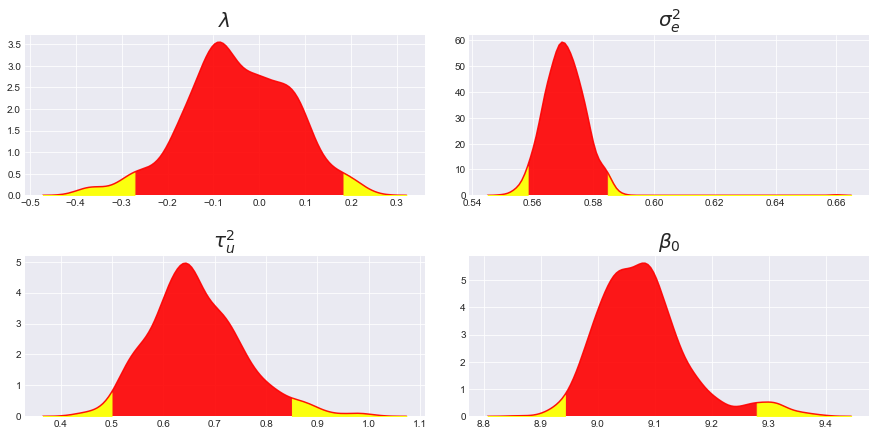

In [447]:
f

<h2>References</h2>

<p>Kruschke, J. K. (2015). Doing Bayesian data analysis, Second
edition: A tutorial with R, JAGS, and Stan. Waltham,
Academic Press/Elsevier</p>